In [1]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

=== DATASET ANALYSIS ===

Distribution of found issues:
----------------------------------
normal: 1379 occurrences
Lung: 553 occurrences
Opacity: 509 occurrences
Cardiomegaly: 345 occurrences
Calcinosis: 332 occurrences
Pulmonary Atelectasis: 330 occurrences
Calcified Granuloma: 276 occurrences
Thoracic Vertebrae: 256 occurrences
Cicatrix: 196 occurrences
Spine: 174 occurrences
Markings: 167 occurrences
Pleural Effusion: 160 occurrences
Aorta: 158 occurrences
Diaphragm: 140 occurrences
Density: 129 occurrences
Atherosclerosis: 125 occurrences
Deformity: 124 occurrences
Airspace Disease: 123 occurrences
Catheters, Indwelling: 121 occurrences
Scoliosis: 118 occurrences
Nodule: 116 occurrences
Granulomatous Disease: 107 occurrences
Surgical Instruments: 105 occurrences
No Indexing: 92 occurrences
Fractures, Bone: 89 occurrences
Aorta, Thoracic: 89 occurrences
Technical Quality of Image Unsatisfactory: 84 occurrences
Costophrenic Angle: 79 occurrences
Osteophyte: 70 occurrences
Pulmonary 

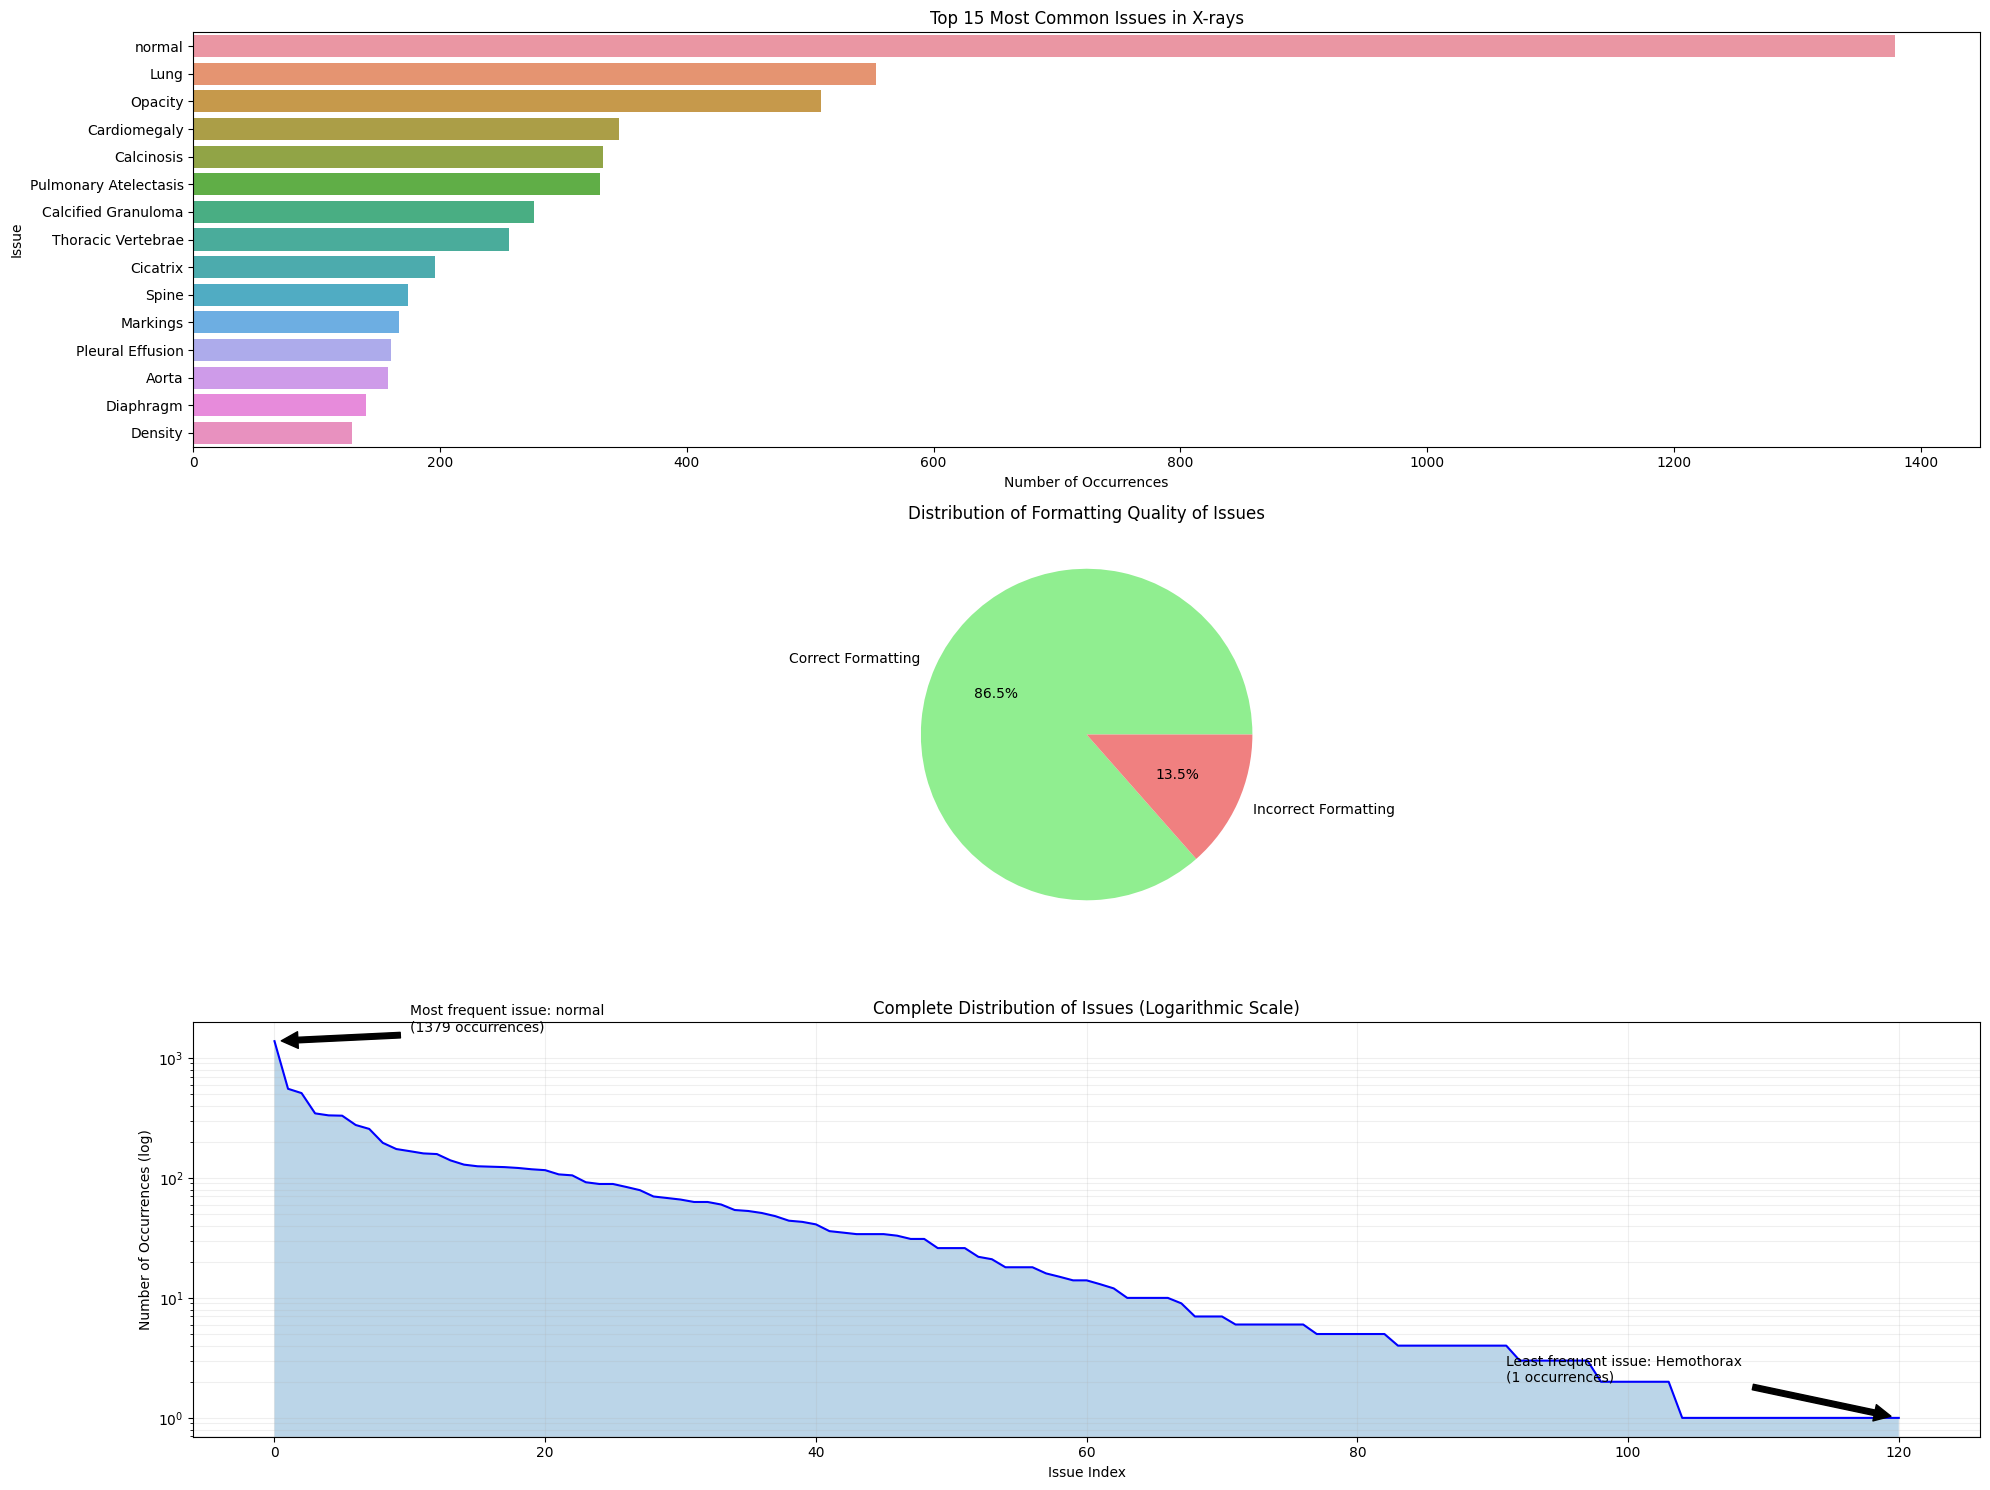

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_xray_dataset(reports_path, projections_path, img_dir):
    """
    Analyzes the chest x-ray dataset, focusing on the issues found
    and identifying rows with formatting problems.
    
    Parameters:
    reports_path (str): Path to the CSV file of reports
    projections_path (str): Path to the CSV file of projections
    img_dir (str): Directory containing the images
    """
    # Load data
    reports_df = pd.read_csv(reports_path)
    projections_df = pd.read_csv(projections_path)
    
    print("=== DATASET ANALYSIS ===\n")
    
    # Analysis of issues
    # Separate multiple issues (divided by ;)
    all_problems = []
    
    # Count of formatting issues
    bad_formatting_count = 0
    well_formatted_count = 0
    
    for problems in reports_df['Problems'].dropna():
        problems_str = str(problems)
        # Check for formatting issues
        if problems_str == "No Indexing" or "," in problems_str:
            bad_formatting_count += 1
        else:
            well_formatted_count += 1
        all_problems.extend([p.strip() for p in problems_str.split(';')])
    
    # Count of problems
    problem_counts = pd.Series(all_problems).value_counts()
    
    print("Distribution of found issues:")
    print("----------------------------------")
    for problem, count in problem_counts.items():
        print(f"{problem}: {count} occurrences")
    
    print(f"\nTotal number of unique problems: {len(problem_counts)}\n")
    
    print("Formatting analysis:")
    print("--------------------------")
    print(f"Rows with correct formatting: {well_formatted_count}")
    print(f"Rows with incorrect formatting: {bad_formatting_count}")
    
    # Create a figure with 3 subplots
    plt.figure(figsize=(20, 15))
    
    # 1. Top 15 issues
    plt.subplot(3, 1, 1)
    top_problems = problem_counts.head(15)
    sns.barplot(x=top_problems.values, y=top_problems.index)
    plt.title('Top 15 Most Common Issues in X-rays')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Issue')
    
    # 2. Pie chart for formatting quality
    plt.subplot(3, 1, 2)
    labels = ['Correct Formatting', 'Incorrect Formatting']
    sizes = [well_formatted_count, bad_formatting_count]
    colors = ['lightgreen', 'lightcoral']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    plt.title('Distribution of Formatting Quality of Issues')
    
    # 3. Complete distribution of issues (logarithmic scale)
    plt.subplot(3, 1, 3)
    
    # Create a line plot for all issues
    x = range(len(problem_counts))
    plt.plot(x, problem_counts.values, 'b-')
    plt.fill_between(x, problem_counts.values, alpha=0.3)
    plt.yscale('log')  # Logarithmic scale for better visualization of differences
    plt.title('Complete Distribution of Issues (Logarithmic Scale)')
    plt.xlabel('Issue Index')
    plt.ylabel('Number of Occurrences (log)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add some annotations to highlight the imbalance
    plt.annotate(f'Most frequent issue: {problem_counts.index[0]}\n({problem_counts.values[0]} occurrences)',
                xy=(0, problem_counts.values[0]),
                xytext=(10, problem_counts.values[0]*1.2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.annotate(f'Least frequent issue: {problem_counts.index[-1]}\n({problem_counts.values[-1]} occurrences)',
                xy=(len(problem_counts)-1, problem_counts.values[-1]),
                xytext=(len(problem_counts)-30, problem_counts.values[-1]*2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()
    
    return problem_counts, well_formatted_count, bad_formatting_count

PROJECTIONS_PATH = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
REPORTS_PATH = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
IMG_DIR = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'

problems_count, missing_probs, missing_imgs = analyze_xray_dataset(
    REPORTS_PATH,
    PROJECTIONS_PATH,
    IMG_DIR
)

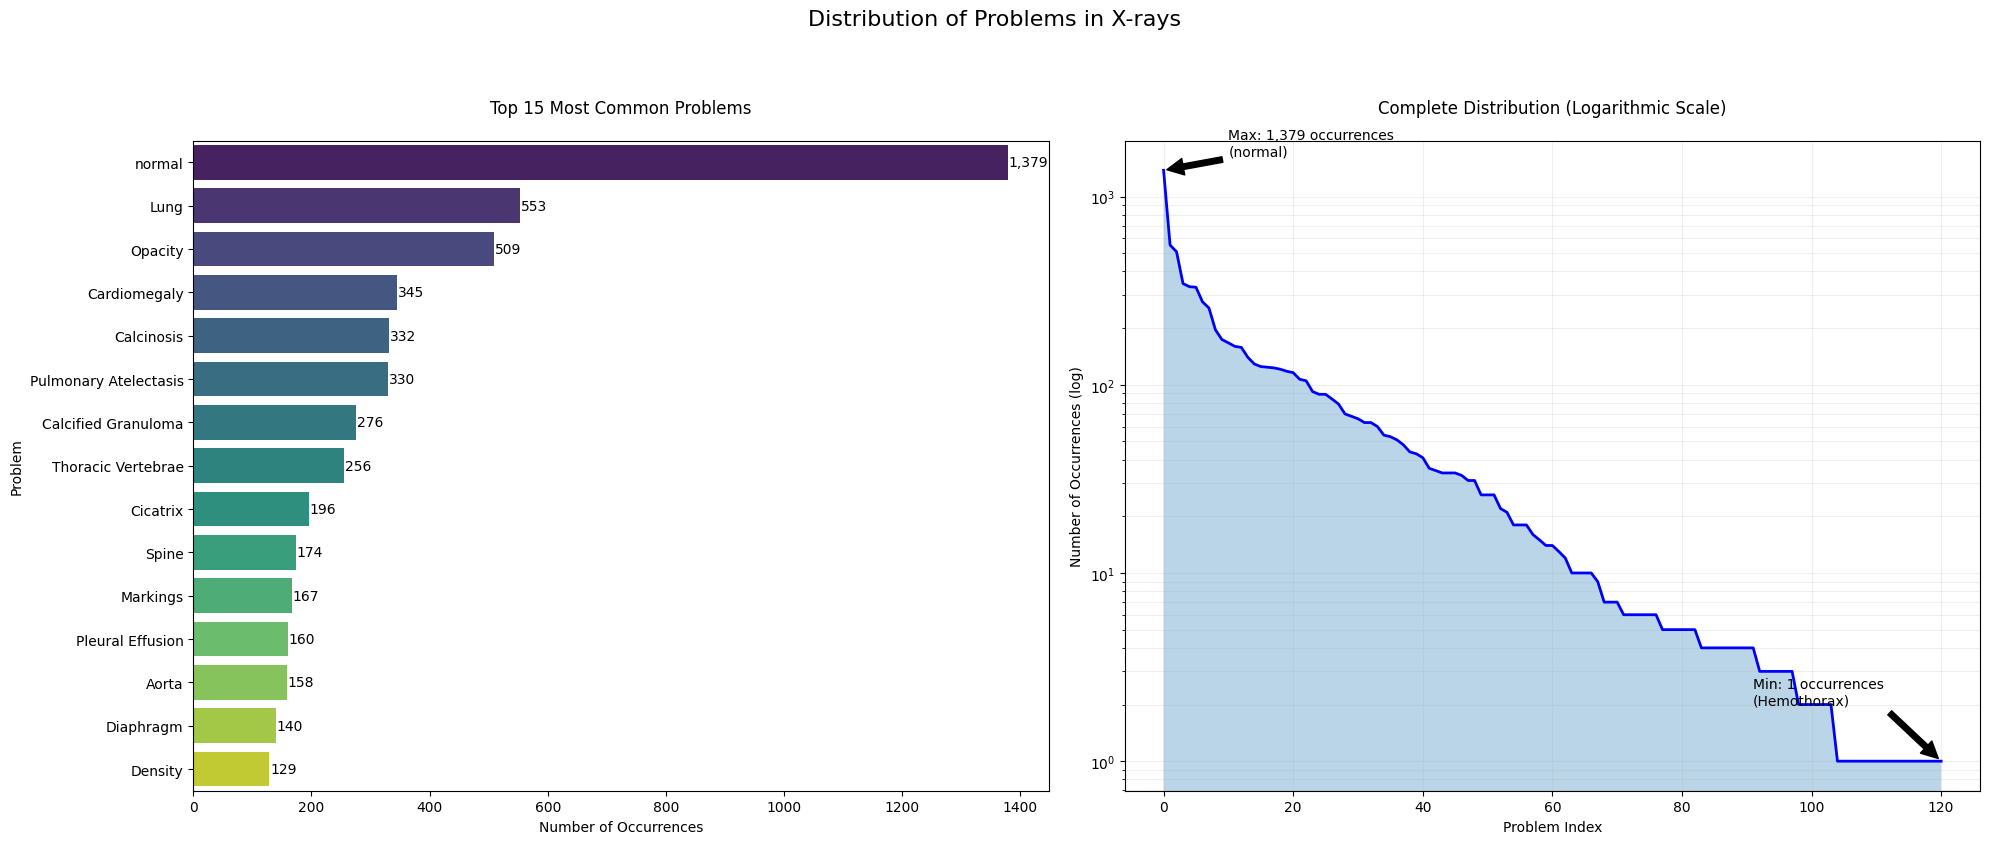


Statistics on the distribution of problems:
Total number of unique problems: 121
Most frequent problem: normal (1,379 occurrences)
Least frequent problem: Hemothorax (1 occurrences)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_problem_distribution(reports_path):
    # Load and preprocess data
    reports_df = pd.read_csv(reports_path)
    
    # Extract and count problems
    all_problems = []
    for problems in reports_df['Problems'].dropna():
        problems_str = str(problems)
        all_problems.extend([p.strip() for p in problems_str.split(';')])
    
    problem_counts = pd.Series(all_problems).value_counts()
    
    # Create the figure with two side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Distribution of Problems in X-rays', fontsize=16, y=1.05)
    
    # Plot 1: Top 15 problems (normal scale)
    top_15 = problem_counts.head(15)
    sns.barplot(x=top_15.values, y=top_15.index, ax=ax1, palette='viridis')
    ax1.set_title('Top 15 Most Common Problems', pad=20)
    ax1.set_xlabel('Number of Occurrences')
    ax1.set_ylabel('Problem')
    
    # Add values on bars
    for i, v in enumerate(top_15.values):
        ax1.text(v + 1, i, f'{v:,}', va='center')
    
    # Plot 2: Complete distribution (logarithmic scale)
    x = range(len(problem_counts))
    ax2.plot(x, problem_counts.values, 'b-', linewidth=2)
    ax2.fill_between(x, problem_counts.values, alpha=0.3)
    ax2.set_yscale('log')
    ax2.set_title('Complete Distribution (Logarithmic Scale)', pad=20)
    ax2.set_xlabel('Problem Index')
    ax2.set_ylabel('Number of Occurrences (log)')
    ax2.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add annotations for extreme values
    ax2.annotate(f'Max: {problem_counts.values[0]:,} occurrences\n({problem_counts.index[0]})',
                xy=(0, problem_counts.values[0]),
                xytext=(10, problem_counts.values[0]*1.2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax2.annotate(f'Min: {problem_counts.values[-1]:,} occurrences\n({problem_counts.index[-1]})',
                xy=(len(problem_counts)-1, problem_counts.values[-1]),
                xytext=(len(problem_counts)-30, problem_counts.values[-1]*2),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print("\nStatistics on the distribution of problems:")
    print(f"Total number of unique problems: {len(problem_counts):,}")
    print(f"Most frequent problem: {problem_counts.index[0]} ({problem_counts.values[0]:,} occurrences)")
    print(f"Least frequent problem: {problem_counts.index[-1]} ({problem_counts.values[-1]:,} occurrences)")

# Example usage
REPORTS_PATH = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
plot_problem_distribution(REPORTS_PATH)

In [4]:
import pandas as pd

# Load the CSV files
df_image = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df_report = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Create an empty DataFrame for frontal images, lateral images, captions, and problems
df = pd.DataFrame({'front_img': [], 'lateral_img': [], 'captions': [], 'problems': []})

# Loop through each image in the images DataFrame
for uid in df_image['uid'].unique():
    # Find all images for each 'uid'
    front_image = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Frontal')]
    lateral_img = df_image.loc[(df_image['uid'] == uid) & (df_image['projection'] == 'Lateral')]
    
    # If there are both frontal and lateral images
    if not front_image.empty and not lateral_img.empty:
        # Find the corresponding caption
        caption = df_report.loc[df_report['uid'] == uid, 'findings'].values[0]
        # Find the corresponding problems
        problems = df_report.loc[df_report['uid'] == uid, 'Problems'].values[0]
        
        # Add the row to the DataFrame
        df = pd.concat([df, pd.DataFrame([{
            'front_img': front_image.iloc[0]['filename'],
            'lateral_img': lateral_img.iloc[0]['filename'],
            'captions': caption,
            'problems': problems
        }])], axis=0)

# Update the image paths
loc = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
df['front_img'] = loc + df['front_img']
df['lateral_img'] = loc + df['lateral_img']

# Reset the index to ensure it is unique
# This ensures each row has a unique id
df = df.reset_index(drop=True)

# Show the final result
print(df.head())

                                           front_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                         lateral_img  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                            captions  \
0  The cardiac silhouette and mediastinum size ar...   
1  Borderline cardiomegaly. Midline sternotomy XX...   
2                                                NaN   
3  There are diffuse bilateral interstitial and a...   
4  The cardiomediastinal silhouette and pulmon

In [5]:
import pandas as pd

# Select rows that contain 'normal' in the 'problems' column
normal_rows = df[df['problems'].str.contains('normal', na=False)]
print(f"Number of rows with 'Normal': {len(normal_rows)}")

# Randomly select 50% of these rows to remove
rows_to_remove = normal_rows.sample(frac=0.5, random_state=42).index

print(f"Length of df before drop: {len(df)}")
df = df.drop(rows_to_remove)
print(f"Length of df after drop: {len(df)}")

Number of rows with 'Normal': 1244
Length of df before drop: 3388
Length of df after drop: 2766


In [6]:
# Calculate the occurrences of each problem
problem_counts = {}
for problems in df['problems'].dropna():
    for problem in problems.split(';'):
        problem = problem.strip()  # Remove extra spaces
        problem_counts[problem] = problem_counts.get(problem, 0) + 1

# Define the problems to delete
problems_to_delete = [
    "No Indexing",
    "Technical Quality of Image Unsatisfactory",
    "Foreign Bodies",
    "Calcinosis",
    "Density",
    "Diaphragm",
    "Diaphragmatic Eventration",
    "Hernia, Hiatal",
    "Catheters, Indwelling",
    "Surgical Instruments",
    "Implanted Medical Device",
    "Medical Device",
    "Lucency",
    "Tube, Inserted",
    "Markings",
]

# Function to filter the problems of a row
def filter_problems(problems, threshold=20):
    """
    Removes problems with occurrences below the threshold value.
    Also removes the problem "No Indexing".
    Returns a string with the filtered problems or None if none remain.
    """
    if not problems:  # Check if the field is empty or NaN
        return None
    filtered_problems = [
        problem.strip() for problem in problems.split(';')
        if problem_counts.get(problem.strip(), 0) >= threshold and problem.strip() not in problems_to_delete
    ]
    return ';'.join(filtered_problems) if filtered_problems else None

# Apply the filter to the problems
df['problems'] = df['problems'].apply(filter_problems)

# Drop rows with no remaining problems
df = df.dropna(subset=['problems']).reset_index(drop=True)

# Results
print(f"Dataset after cleaning: {len(df)} rows remaining.")

Dataset after cleaning: 2494 rows remaining.


In [7]:
import pandas as pd

def count_problems_occurrences(df):
    """
    Counts and prints the problems and the number of occurrences of each in the dataset.
    
    Args:
    df (pd.DataFrame): DataFrame containing the 'problems' column.
    """
    # Check that the 'problems' column exists
    if 'problems' not in df.columns:
        print("The 'problems' column is not present in the DataFrame.")
        return
    
    # Separate the problems if they are multiple (e.g., separated by a semicolon)
    all_problems = df['problems'].dropna().str.split(';')
    
    # Flatten the list of problems and count occurrences
    problem_counts = {}
    for problem_list in all_problems:
        for problem in problem_list:
            problem = problem.strip()  # Remove any leading or trailing whitespace
            problem_counts[problem] = problem_counts.get(problem, 0) + 1
    
    # Sort the problems by number of occurrences (descending)
    sorted_problems = sorted(problem_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Print the results
    print("Problems and occurrences:")
    for problem, count in sorted_problems:
        print(f"{problem}: {count}")

# Example usage of the function
count_problems_occurrences(df)

Problems and occurrences:
normal: 622
Lung: 490
Opacity: 430
Cardiomegaly: 288
Pulmonary Atelectasis: 286
Calcified Granuloma: 241
Thoracic Vertebrae: 217
Cicatrix: 171
Spine: 150
Aorta: 135
Pleural Effusion: 132
Nodule: 106
Atherosclerosis: 103
Granulomatous Disease: 101
Deformity: 99
Airspace Disease: 99
Scoliosis: 95
Fractures, Bone: 77
Aorta, Thoracic: 76
Costophrenic Angle: 66
Osteophyte: 64
Spondylosis: 61
Pulmonary Congestion: 61
Infiltrate: 53
Emphysema: 50
Granuloma: 50
Thickening: 47
Pulmonary Disease, Chronic Obstructive: 44
Cardiac Shadow: 44
Pulmonary Edema: 39
Pneumonia: 34
Arthritis: 32
Pulmonary Emphysema: 32
Consolidation: 24
Mediastinum: 24
Kyphosis: 24
Bone Diseases, Metabolic: 23
Spinal Fusion: 21
Pneumothorax: 20


In [8]:
categories = {
    "No Problem": [
        "normal"
    ],
    "Pulmonary System": [
        "Lung",
        "Pulmonary Atelectasis",
        "Pulmonary Congestion",
        "Pulmonary Disease, Chronic Obstructive",
        "Pulmonary Emphysema",
        "Pulmonary Edema",
        "Infiltrate",
        "Emphysema",
        "Granuloma",
        "Airspace Disease",
        "Pleural Effusion",
        "Pneumonia",
        "Thickening",
        "Consolidation",
        "Pneumothorax",
        "Granulomatous Disease",
        "Calcified Granuloma",
        "Costophrenic Angle",
    ],
    "Cardiovascular System": [
        "Cardiomegaly",
        "Aorta",
        "Aorta, Thoracic",
        "Atherosclerosis",
        "Pulmonary Edema",
        "Cardiac Shadow",
        "Mediastinum",
    ],
    "Musculoskeletal System": [
        "Thoracic Vertebrae",
        "Spine",
        "Scoliosis",
        "Kyphosis",
        "Deformity",
        "Osteophyte",
        "Spondylosis",
        "Cicatrix",
        "Fractures, Bone",
        "Bone Diseases, Metabolic",
        "Spinal Fusion",
        "Arthritis",
    ]
}

# Create a new column 'categories' based on the problems
def assign_categories(problems, categories_dict):
    """
    Assigns a macro category based on the problems using the categories dictionary.
    """
    if not problems:  # If there are no problems, return None
        return None
    
    assigned_categories = set()  # To keep track of assigned macro categories
    for problem in problems.split(';'):
        problem = problem.strip()
        for category, problem_list in categories_dict.items():
            if problem in problem_list:
                assigned_categories.add(category)
    
    # If no macro category is assigned, return None
    if len(assigned_categories) == 0:
        return None
    # If more than one macro category is assigned, return 'Multiple'
    elif len(assigned_categories) > 1:
        return 'Multiple'
    # Otherwise, return the single assigned macro category
    else:
        return assigned_categories.pop()

# Apply the function to the dataset
df['categories'] = df['problems'].apply(lambda x: assign_categories(x, categories))

# Drop rows without assigned macro categories
df = df.dropna(subset=['categories'])

# Drop rows with more than one assigned macro category
df = df[df['categories'] != 'Multiple']

# Reset the index after cleaning
df = df.reset_index(drop=True)

# Show the final result
print(f"Dataset after cleaning: {len(df)} rows remaining.")

Dataset after cleaning: 1716 rows remaining.


In [9]:
# Count the occurrences of each macro problem (category)
category_counts = df['categories'].value_counts()
# Print the occurrences
print("Occurrences of each macro problem:")
print(category_counts)

Occurrences of each macro problem:
categories
No Problem                622
Pulmonary System          616
Musculoskeletal System    324
Cardiovascular System     154
Name: count, dtype: int64


In [10]:
#VARIABLE USED IN MANY CELLS AND IN THE MODEL
num_class_pred = 4

In [11]:
from transformers import AutoTokenizer, GPT2TokenizerFast

# Use GPT2 tokenizer which is better suited for text generation
# The specific tokenizer for the GPT-2 model is loaded using the from_pretrained() method.
# The tokenizer is used to transform text into sequences of tokens (minimal units of meaning for the model) and vice versa.
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
# The padding token (pad_token) is set for the tokenizer. In many models, padding is used to make input sequences of equal length by filling shorter sequences with a special token.

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((384, 384)), # Resize the images to the standard format
    transforms.ToTensor(),  # Transform the image into a PyTorch tensor. This operation normalizes the pixel values
])

In [13]:
from torch.utils.data import Dataset
from PIL import Image

'''
caption and problem are encoded through the tokenizer. It transforms the text into a sequence of tokens (numeric IDs).
This process returns:
- input_ids: numerical representation of the text.
- attention_mask: mask indicating which tokens are valid.
Example:
1)  "The X-ray shows an opaque area in the upper right lobe."
2)  ['The', 'X-ray', 'shows', 'an', 'opaque', 'area', 'in', 'the', 'upper', 'right', 'lobe', '.']
3)  [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102]   101 and 102 are special start and end characters.
4)  Tokenized input: [101, 4120, 5123, 1132, 4172, 3090, 1209, 8765, 3040, 8712, 102, 0, 0, 0, ...]
    Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...]
Since models work with fixed-length sequences (e.g., 128 tokens), shorter texts are padded with special tokens (padding, 0).
The attention mask indicates which tokens are part of the original text (1) and which are padding (0).
'''
class LoadDataset(Dataset):
    def __init__(self, df):
        self.front_images = df['front_img'].values  # Column of frontal images
        self.lateral_images = df['lateral_img'].values  # Column of lateral images
        self.captions = df['captions'].values  # Column of captions
        self.problems = df['problems'].values  # Column of problems
        self.zone_categories = df['categories'].values  # Column of risk categories

        # Map of risk categories to indices (for one-hot encoding)
        self.risk_mapping = {
            'No Problem': 0,
            'Pulmonary System': 1,
            'Cardiovascular System': 2,
            'Musculoskeletal System': 3
        }
        
    # The __getitem__ method retrieves the frontal and lateral images and the corresponding caption
    def __getitem__(self, idx):
        # Load the frontal and lateral images
        front_image_path = str(self.front_images[idx])
        lateral_image_path = str(self.lateral_images[idx])
        
        # Open the images and convert them to RGB
        front_image = Image.open(front_image_path).convert("RGB")
        lateral_image = Image.open(lateral_image_path).convert("RGB")
        
        # Apply transformations to the images (to be defined)
        front_image = transform(front_image)
        lateral_image = transform(lateral_image)

        # Retrieve the caption, problem, and risk category
        caption = str(self.captions[idx])
        problem = str(self.problems[idx])
        categories = self.zone_categories[idx] 
        
        # Encode the caption using the tokenizer
        encoded_caption = tokenizer(
            caption,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Encode the problem using the tokenizer
        encoded_problem = tokenizer(
            problem,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # One-hot encoding of the risk category
        categories = self.zone_categories[idx]
        risk_label = self.risk_mapping.get(categories, 0)  # Default to 0 if the category does not exist
        risk_one_hot = F.one_hot(torch.tensor(risk_label), num_classes=num_class_pred).float()
        
        # Return the images and the encoded caption and encoded problem
        return {
            'front_pixel_values': front_image,  # Frontal image
            'lateral_pixel_values': lateral_image,  # Lateral image
            'input_ids_caption': encoded_caption['input_ids'].squeeze(0),  # Input IDs of the caption
            'attention_mask_caption': encoded_caption['attention_mask'].squeeze(0),  # Attention Mask for the caption
            'categories': risk_one_hot 
        }

    def __len__(self):  # Method that returns the length of the dataset
        return len(self.front_images)

In [14]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train, test, and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.3, shuffle=True, random_state=42)

# Create custom datasets for train, test, and validation
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
valid_ds = LoadDataset(valid_df)

In [15]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetEncoder(nn.Module):
    def __init__(self, trainable_layers=6):
        super(ResNetEncoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Remove the classification head
        self.model.fc = nn.Identity()
        
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze the last `trainable_layers` layers
        self._unfreeze_last_layers(trainable_layers)

    def _unfreeze_last_layers(self, trainable_layers):
        # Get the layers in order (children) and unfreeze the last n
        children = list(self.model.children())  
        for layer in children[-trainable_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Return the feature vector (dim=2048)
        return self.model(x)  # shape [B, 2048]

In [16]:
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Config
import torchvision.models as models

class ImageCaptioningModel(nn.Module):
    def __init__(self):
        super(ImageCaptioningModel, self).__init__()
        
        # Two ResNet encoders, one for the front image and one for the lateral image
        self.encoder_front = ResNetEncoder(trainable_layers=4)
        self.encoder_lateral = ResNetEncoder(trainable_layers=4)

        # With ResNet50, each encoder produces a vector of dim=2048
        # -> concatenating front + lateral you will have 4096 features.
        # **Addition of Separate Classifier**
        self.classifier = nn.Sequential(
            nn.Linear(4096, 256),   # (2048 + 2048) -> 4096
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(8, num_class_pred)  # Output layer for classification
        )
        
        # Decoder GPT2 with cross-attention
        config = GPT2Config.from_pretrained('gpt2')
        config.add_cross_attention = True
        self.decoder = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

        # Un Freeze everything initially
        for param in self.decoder.parameters():
            param.requires_grad = True
        
        # Freeze only the first layer
        for name, param in self.decoder.named_parameters():
            if "wte" in name or "h.0" in name:  # Embedding layer ("wte") or first Transformer block ("h.0")
                param.requires_grad = False
        
        # Projection of concatenated features into the format required by the GPT-2 decoder
        self.feature_projection = nn.Linear(2048 * 2, self.decoder.config.hidden_size)  # Concatenation of features from both images
        self.projection_layer_norm = nn.LayerNorm(self.decoder.config.hidden_size)

    def forward(self, front_image, lateral_img, input_ids_caption, attention_mask_caption):
        # Extract latent features from the images (front and lateral)
        front_image_features = self.encoder_front(front_image)  # Shape: [B, 2048]
        lateral_img_features = self.encoder_lateral(lateral_img)  # Shape: [B, 2048]
        
        # Concatenate the latent features extracted from the two images
        combined_features = torch.cat((front_image_features, lateral_img_features), dim=-1)  # Shape: [B, 4096]

        # **Separate Pass to the Classifier**
        classification_logits = self.classifier(combined_features)  # Shape: [B, num_class_pred]
        
        # Project the concatenated features into space compatible with the GPT-2 decoder
        projected_features = self.feature_projection(combined_features)
        projected_features = self.projection_layer_norm(projected_features)
        
        # Expand the features to match the length of the input sequence
        seq_length = input_ids_caption.shape[1]
        projected_features = projected_features.unsqueeze(1).expand(-1, seq_length, -1).contiguous()  # Shape: [B, seq_length, hidden_size]
        
        # Pass the caption to the GPT-2 decoder
        caption_outputs = self.decoder(
            input_ids=input_ids_caption,
            attention_mask=attention_mask_caption,
            labels=input_ids_caption,
            encoder_hidden_states=projected_features,
            output_hidden_states=True
        )
        
        return {
            'caption_outputs': caption_outputs,
            'classification_logits': classification_logits  # Logits for classification
        }

    def generate_report(self, front_image, lateral_img, max_length=60, device=None):
            # Combine the latent space
            front_image_features = self.encoder_front(front_image)
            lateral_img_features = self.encoder_lateral(lateral_img)
            combined_features = torch.cat((front_image_features, lateral_img_features), dim=-1)
            projected_features = self.feature_projection(combined_features)
            projected_features = self.projection_layer_norm(projected_features).unsqueeze(1)
    
            # Start token (gpt2 does not have bos_token, eos is reused as start)
            batch_size = front_image.size(0)
            start_token = torch.LongTensor([tokenizer.eos_token_id]).to(device)
            start_token = start_token.unsqueeze(0).expand(batch_size, 1)
    
            # Create an attention mask for the input tokens
            attention_mask = torch.ones_like(start_token).to(device)
    
            # Pure generation from the latent space
            generated_ids = self.decoder.generate(
                input_ids=start_token,
                attention_mask=attention_mask,
                encoder_hidden_states=projected_features.contiguous(),
                max_length=max_length,
                pad_token_id=tokenizer.eos_token_id,  # Explicitly set the pad_token_id
                do_sample=True
            )
            return generated_ids

In [17]:
import torch

# If the model exists and is on the GPU, free it
if 'model' in globals() and model is not None:
    del model  # delete the reference to the previous model
    torch.cuda.empty_cache()  # clear the unused GPU memory
    
model = ImageCaptioningModel() # create an instance of the above model containing resnet+ decoder gpt2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # OPTIMIZATION: If the GPU is available, the model will be transferred to the GPU to take advantage 
# of parallel computing power, significantly improving performance.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

ImageCaptioningModel(
  (encoder_front): ResNetEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [18]:
# Function to count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    return total_params, trainable_params, frozen_params

# Print the parameter count
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"Total number of parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Frozen parameters: {frozen_params}")

count_parameters(model)

Total number of parameters: 204028700
Trainable parameters: 153089692
Frozen parameters: 50939008


(204028700, 153089692, 50939008)

In [19]:
class WrappedDataLoader:
    def __init__(self, dataloader, shuffle=False, limit_batches=None): # func is a function used to preprocess and move the tensor to GPU
        self.dataloader = dataloader
        self.shuffle = shuffle
        self.address = []
        self.limit_batches = limit_batches
        self.dataset = dataloader.dataset  # Add this line
        batches = iter(self.dataloader)
        
        # Load only the first 'limit_batches' batches if specified
        for i, b in enumerate(batches):
            if self.limit_batches and i >= self.limit_batches:
                break
            self.address.append(b)
            print(f"{i + 1}/{len(batches)} batches loaded", end="\r")
        print()
        print(f"\nLoaded {len(self.address)} batches.")

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.address)
            return iter(self.address)
        return iter(self.address)

# The collate_fn function is used to prepare the data for batch processing. It transforms dict objects 
# (containing images, attention masks, input IDs, risk categories, etc.) into tensors and moves them to the GPU if available.
# It uses torch.stack to create a batch of tensors for each of the keys in the batch. The resulting tensors are transferred 
# to the GPU or CPU based on the availability of the GPU.
def collate_fn(batch):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    front_pixel_values = torch.stack([item['front_pixel_values'] for item in batch]).to(device)
    lateral_pixel_values = torch.stack([item['lateral_pixel_values'] for item in batch]).to(device)
    input_ids_caption = torch.stack([item['input_ids_caption'] for item in batch]).to(device)
    attention_mask_caption = torch.stack([item['attention_mask_caption'] for item in batch]).to(device)
    zone_categories = torch.stack([item['categories'] for item in batch]).to(device)

    return {
        'front_pixel_values': front_pixel_values,
        'lateral_pixel_values': lateral_pixel_values,
        'input_ids_caption': input_ids_caption,
        'attention_mask_caption': attention_mask_caption,
        'categories': zone_categories
    }
    
# Set up data loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
train_loader = WrappedDataLoader(train_loader)
val_loader = DataLoader(valid_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
val_loader = WrappedDataLoader(val_loader)

120/120 batches loaded

Loaded 120 batches.
52/52 batches loaded

Loaded 52 batches.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Simplified implementation of Focal Loss:
    gamma controls the 'focal' effect,
    alpha can weigh one class more than the other (if >1, it penalizes false negatives more).
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', weight=None):
        """
        :param alpha: balance between classes (float). 
                      If you have imbalanced classes, you can use an alpha > 1 for the rare class.
        :param gamma: "focal" parameter (float). Default=2.
        :param reduction: "mean", "sum" or "none". How to aggregate the loss over batches.
        :param weight: weight vector for individual classes, e.g. [0.7, 1.3], 
                       as in CrossEntropyLoss.
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight  # If you want to use a tensor of class weights

    def forward(self, inputs, targets):
        """
        :param inputs: logits of size [B, C], where C=number of classes
        :param targets: labels (class index) of size [B]
        """
        # Standard Cross Entropy (logits -> probabilities)
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        
        # Predicted probabilities for the correct class (pt)
        pt = torch.exp(-ce_loss)  # shape [B]
        
        # Focal Loss
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
class MedicalCaptionLoss(torch.nn.Module):
    """
    This custom loss function is specifically designed for the medical captioning task, 
    where the focus is on accurately describing medical findings in X-ray images. 
    It incorporates weighting to emphasize critical medical terms and anatomical locations in the generated captions.
    """
    
    def __init__(self, tokenizer, problem_terms_weight=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.problem_terms_weight = problem_terms_weight
        
        # Compile regex patterns for medical terms and locations
        self.location_patterns = re.compile(
            r'\b(left|right|lateral|medial|anterior|posterior|upper|lower|mid|'
            r'lung|chest|hilum|hilar|fissure|apex|base|rib|diaphragm|clavicle|'
            r'sternum|thorax|vertebra|costophrenic|subdiaphragmatic|'
            r'mediastinum|cardiomediastinal|perihilar|subcarinal|'
            r'supraclavicular|segment|zone)\b',
            re.IGNORECASE
        )

        # Combine all problems in categories into a single regex pattern
        all_problems = [problem for problems in categories.values() for problem in problems]
        pattern = r'\b(' + '|'.join(re.escape(problem) for problem in all_problems) + r')\b'
        self.medical_patterns = re.compile(pattern, re.IGNORECASE)

    
    def identify_medical_tokens(self, text):
        """Identify positions of medical terms and locations in the text"""
        medical_positions = set()
        
        # Find all medical terms and their positions
        for match in self.medical_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        # Find all location terms and their positions
        for match in self.location_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        return medical_positions

    def forward(self, logits, labels, reference_text):
        """
        Args:
            logits: Model output logits (B, S, V)
            labels: Ground truth labels (B, S)
            reference_text: Original caption text for identifying medical terms
        """
        # Create weight mask for medical terms
        weights = torch.ones_like(labels, dtype=torch.float)
        
        for i, text in enumerate(reference_text):
            medical_positions = self.identify_medical_tokens(text)
            for pos in medical_positions:
                mask = (labels[i] == pos)
                weights[i][mask] = self.problem_terms_weight
        
        # Shift for causal language modeling
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()
        
        # Calculate weighted cross entropy loss
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )
        
        # Apply weights to loss
        weighted_loss = loss * shift_weights.view(-1)
        
        return weighted_loss.mean()

In [22]:
from transformers import Trainer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import re

'''
In the first group (higher lr) I put:
model.decoder (GPT2)
model.feature_projection
model.projection_layer_norm
These are the components responsible for caption generation

In the second group (original lr) I put:
model.classifier
model.encoder_front
model.encoder_lateral
These are the components responsible for classification and image encoding

This way:
The text generation part (GPT2 decoder and associated projections) will have a higher learning rate
The classification part and the encoders will have the original learning rate
'''

# Configuration of parameter groups with model components to modify only certain components.
# However, we noticed that updating all weights together increased generalization, leading to better results
param_groups = [
    {
        'params': list(model.decoder.parameters()) + list(model.feature_projection.parameters()) + 
                 list(model.projection_layer_norm.parameters()),
        'lr': 3e-4  # Higher learning rate for the caption part
    },
    {
        'params': list(model.classifier.parameters()) + list(model.encoder_front.parameters()) + 
                 list(model.encoder_lateral.parameters()),
        'lr': 5e-5  # Original learning rate for classification and encoders
    }
]
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# The compute_loss function calculates the model loss using cross-entropy between logits and reference labels.
def compute_loss(logits, labels):
    # Shift logits and labels for cross-entropy
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

def train(model, train_loader, val_loader, optimizer, tokenizer, epochs=15):
    criterion_classification = FocalLoss(alpha=1.0, gamma=2.0)
    criterion_caption = MedicalCaptionLoss(tokenizer)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss_caption = 0
        total_train_loss_classification = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            # tensors are already on the GPU thanks to collate_fn
            optimizer.zero_grad()

            outputs = model(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                input_ids_caption=batch['input_ids_caption'],
                attention_mask_caption=batch['attention_mask_caption']
            )
            
            # Get original captions for medical term identification
            original_captions = [tokenizer.decode(ids) for ids in batch['input_ids_caption']]
            # Calculate caption loss with medical term weighting
            caption_loss = criterion_caption(
                outputs['caption_outputs'].logits,
                batch['input_ids_caption'],
                original_captions
            )
            

            # Calculate the loss for the classification of risk categories
            classification_logits = outputs['classification_logits']
            labels = torch.argmax(batch['categories'], dim=1)  # [B]
            classification_loss = criterion_classification(classification_logits, labels)
            
            # Total loss is the sum of caption and classification loss
            total_loss = caption_loss + classification_loss
            total_loss.backward()
            optimizer.step()

            total_train_loss_caption += caption_loss.item()
            total_train_loss_classification += classification_loss.item()

        avg_train_loss_caption = total_train_loss_caption / len(train_loader)
        avg_train_loss_classification = total_train_loss_classification / len(train_loader)
        print(f"Epoch {epoch + 1} - Train Caption Loss: {avg_train_loss_caption:.4f}")
        print(f"Epoch {epoch + 1} - Train Classification Loss: {avg_train_loss_classification:.4f}")

        # ------------------
        #    VALIDATION
        # ------------------
        model.eval()
        total_val_loss_caption = 0
        total_val_loss_classification = 0
        total_correct_classifications = 0
        total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                 # tensors are already on the GPU thanks to collate_fn
                outputs = model(
                    front_image=batch['front_pixel_values'],
                    lateral_img=batch['lateral_pixel_values'],
                    input_ids_caption=batch['input_ids_caption'],
                    attention_mask_caption=batch['attention_mask_caption']
                )

                # Calculate the loss for caption generation
                caption_loss = outputs['caption_outputs'].loss
                total_val_loss_caption += caption_loss.item()

                # Calculate the loss for the classification of risk categories
                classification_logits = outputs['classification_logits']
                labels = torch.argmax(batch['categories'], dim=1)
                classification_loss = criterion_classification(classification_logits, labels)
                total_val_loss_classification += classification_loss.item()
                    
                # Calculate correct classifications
                predicted_labels = torch.argmax(classification_logits, dim=1)
                total_correct_classifications += (predicted_labels == labels).sum().item()
                total_samples += labels.size(0)

        avg_val_loss_caption = total_val_loss_caption / len(val_loader)
        avg_val_loss_classification = total_val_loss_classification / len(val_loader)

        print(f"Epoch {epoch + 1} - Validation Caption Loss: {avg_val_loss_caption:.4f}")
        print(f"Epoch {epoch + 1} - Validation Classification Loss: {avg_val_loss_classification:.4f}")

        # Clear the GPU cache
        torch.cuda.empty_cache()

    print("\nTraining completed!")

# Start training
train(model, train_loader, val_loader, optimizer, tokenizer)

Epoch 1/15: 100%|██████████| 120/120 [01:20<00:00,  1.48it/s]


Epoch 1 - Train Caption Loss: 1.2662
Epoch 1 - Train Classification Loss: 0.9326
Epoch 1 - Validation Caption Loss: 0.7270
Epoch 1 - Validation Classification Loss: 0.8479


Epoch 2/15: 100%|██████████| 120/120 [01:27<00:00,  1.36it/s]


Epoch 2 - Train Caption Loss: 0.7377
Epoch 2 - Train Classification Loss: 0.7881
Epoch 2 - Validation Caption Loss: 0.5742
Epoch 2 - Validation Classification Loss: 0.8239


Epoch 3/15: 100%|██████████| 120/120 [01:27<00:00,  1.37it/s]


Epoch 3 - Train Caption Loss: 0.5932
Epoch 3 - Train Classification Loss: 0.6806
Epoch 3 - Validation Caption Loss: 0.5159
Epoch 3 - Validation Classification Loss: 0.7941


Epoch 4/15: 100%|██████████| 120/120 [01:27<00:00,  1.37it/s]


Epoch 4 - Train Caption Loss: 0.5231
Epoch 4 - Train Classification Loss: 0.5987
Epoch 4 - Validation Caption Loss: 0.4815
Epoch 4 - Validation Classification Loss: 0.8100


Epoch 5/15: 100%|██████████| 120/120 [01:27<00:00,  1.38it/s]


Epoch 5 - Train Caption Loss: 0.4758
Epoch 5 - Train Classification Loss: 0.5557
Epoch 5 - Validation Caption Loss: 0.4568
Epoch 5 - Validation Classification Loss: 0.7781


Epoch 6/15: 100%|██████████| 120/120 [01:27<00:00,  1.38it/s]


Epoch 6 - Train Caption Loss: 0.4364
Epoch 6 - Train Classification Loss: 0.5081
Epoch 6 - Validation Caption Loss: 0.4443
Epoch 6 - Validation Classification Loss: 0.7811


Epoch 7/15: 100%|██████████| 120/120 [01:27<00:00,  1.37it/s]


Epoch 7 - Train Caption Loss: 0.4024
Epoch 7 - Train Classification Loss: 0.4937
Epoch 7 - Validation Caption Loss: 0.4368
Epoch 7 - Validation Classification Loss: 0.7563


Epoch 8/15: 100%|██████████| 120/120 [01:27<00:00,  1.37it/s]


Epoch 8 - Train Caption Loss: 0.3742
Epoch 8 - Train Classification Loss: 0.4429
Epoch 8 - Validation Caption Loss: 0.4319
Epoch 8 - Validation Classification Loss: 0.7606


Epoch 9/15: 100%|██████████| 120/120 [01:27<00:00,  1.38it/s]


Epoch 9 - Train Caption Loss: 0.3499
Epoch 9 - Train Classification Loss: 0.4251
Epoch 9 - Validation Caption Loss: 0.4276
Epoch 9 - Validation Classification Loss: 0.7467


Epoch 10/15: 100%|██████████| 120/120 [01:27<00:00,  1.38it/s]


Epoch 10 - Train Caption Loss: 0.3252
Epoch 10 - Train Classification Loss: 0.4079
Epoch 10 - Validation Caption Loss: 0.4332
Epoch 10 - Validation Classification Loss: 0.7509


Epoch 11/15: 100%|██████████| 120/120 [01:27<00:00,  1.37it/s]


Epoch 11 - Train Caption Loss: 0.3035
Epoch 11 - Train Classification Loss: 0.3891
Epoch 11 - Validation Caption Loss: 0.4293
Epoch 11 - Validation Classification Loss: 0.7325


Epoch 12/15: 100%|██████████| 120/120 [01:27<00:00,  1.36it/s]


Epoch 12 - Train Caption Loss: 0.2834
Epoch 12 - Train Classification Loss: 0.3699
Epoch 12 - Validation Caption Loss: 0.4315
Epoch 12 - Validation Classification Loss: 0.7268


Epoch 13/15: 100%|██████████| 120/120 [01:27<00:00,  1.36it/s]


Epoch 13 - Train Caption Loss: 0.2633
Epoch 13 - Train Classification Loss: 0.3624
Epoch 13 - Validation Caption Loss: 0.4480
Epoch 13 - Validation Classification Loss: 0.7214


Epoch 14/15: 100%|██████████| 120/120 [01:27<00:00,  1.37it/s]


Epoch 14 - Train Caption Loss: 0.2461
Epoch 14 - Train Classification Loss: 0.3477
Epoch 14 - Validation Caption Loss: 0.4534
Epoch 14 - Validation Classification Loss: 0.7084


Epoch 15/15: 100%|██████████| 120/120 [01:27<00:00,  1.37it/s]


Epoch 15 - Train Caption Loss: 0.2310
Epoch 15 - Train Classification Loss: 0.3287
Epoch 15 - Validation Caption Loss: 0.4511
Epoch 15 - Validation Classification Loss: 0.6906

Training completed!


In [29]:
import os
import torch

# Define the save directory
save_directory = "./saved_model"
os.makedirs(save_directory, exist_ok=True)

# Save the model state dictionary
torch.save(model.state_dict(), os.path.join(save_directory, "model.pth"))

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./saved_model


In [30]:
import os
import torch
from transformers import AutoTokenizer

# Path to the directory of the loaded dataset
saved_model_dir = "/kaggle/input/save-model"

# Load the model
model = ImageCaptioningModel()  # Replace with your model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(os.path.join(saved_model_dir, "model.pth"), map_location=device))
model.to(device)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)

print("Model and tokenizer loaded successfully!")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/save-model/model.pth'

In [ ]:
!pip install rouge-score

In [ ]:
test_loader = DataLoader(train_ds, batch_size=8, collate_fn=collate_fn)
test_loader = WrappedDataLoader(test_loader)

In [ ]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import warnings
import logging
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Disable all warnings
warnings.filterwarnings('ignore')
# Ignore specific warnings from 'transformers'
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
# Set logging level to ERROR to ignore INFO and WARNING messages
logging.getLogger("transformers").setLevel(logging.ERROR)

def calculate_bleu(pred_ids, ref_ids, tokenizer):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores.
    """
    pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids)
    ref_tokens = tokenizer.convert_ids_to_tokens(ref_ids)

    # Avoid issues with empty sequences
    if not pred_tokens or not ref_tokens:
        return (0.0, 0.0, 0.0, 0.0)

    smoothing = SmoothingFunction().method1
    bleu1 = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    return bleu1, bleu2, bleu3, bleu4

def calculate_rouge_l(predicted_text, reference_text):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(reference_text, predicted_text)
    return score['rougeL'].fmeasure
    
def test(model, test_loader, tokenizer):
    model.eval()
    total_bleu1 = total_bleu2 = total_bleu3 = total_bleu4 = 0
    total_rouge_l = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Generate reports only from latent space
            gen_ids = model.generate_report(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                device=device
            )

            # Calculate BLEU and ROUGE-L scores on generated texts
            for pred_ids, ref_ids in zip(gen_ids, batch['input_ids_caption']):
                bleu1, bleu2, bleu3, bleu4 = calculate_bleu(pred_ids.tolist(), ref_ids.tolist(), tokenizer)
                total_bleu1 += bleu1
                total_bleu2 += bleu2
                total_bleu3 += bleu3
                total_bleu4 += bleu4

                predicted_text = tokenizer.decode(pred_ids.tolist(), skip_special_tokens=True)
                reference_text = tokenizer.decode(ref_ids.tolist(), skip_special_tokens=True)
                rouge_l_score = calculate_rouge_l(predicted_text, reference_text)
                total_rouge_l += rouge_l_score

    dataset_size = len(test_loader.dataset)
    metrics = {
        'bleu1': total_bleu1 / dataset_size,
        'bleu2': total_bleu2 / dataset_size,
        'bleu3': total_bleu3 / dataset_size,
        'bleu4': total_bleu4 / dataset_size,
        'rouge_l': total_rouge_l / dataset_size
    }

    print("\nTest Results:")
    print(f"BLEU-1 Score: {metrics['bleu1']:.4f}")
    print(f"BLEU-2 Score: {metrics['bleu2']:.4f}")
    print(f"BLEU-3 Score: {metrics['bleu3']:.4f}")
    print(f"BLEU-4 Score: {metrics['bleu4']:.4f}")
    print(f"ROUGE-L Score: {metrics['rouge_l']:.4f}")

    return metrics

def visualize_predictions(model, test_loader, tokenizer, num_images=5):
    model.eval()
    visualizations_shown = 0

    with torch.no_grad():
        for batch in test_loader:
            gen_ids = model.generate_report(
                front_image=batch['front_pixel_values'],
                lateral_img=batch['lateral_pixel_values'],
                device=device
            )

            for i in range(len(gen_ids)):
                if visualizations_shown >= num_images:
                    return

                # Decode captions and problems
                pred_caption = tokenizer.decode(gen_ids[i].tolist(), skip_special_tokens=True)
                true_caption = tokenizer.decode(batch['input_ids_caption'][i].tolist(), skip_special_tokens=True)
                
                # Plot images
                plt.figure(figsize=(10, 5))

                # Plot frontal image
                plt.subplot(1, 2, 1)
                plt.imshow(batch['front_pixel_values'][i].cpu().permute(1, 2, 0))
                plt.axis('off')
                plt.title('Frontal View')

                # Plot lateral image
                plt.subplot(1, 2, 2)
                plt.imshow(batch['lateral_pixel_values'][i].cpu().permute(1, 2, 0))
                plt.axis('off')
                plt.title('Lateral View')

                plt.show()

                # Print predictions and true values
                print(f"True Caption: {true_caption}")
                print(f"Pred Caption: {pred_caption}")
                print('-' * 50)

                visualizations_shown += 1

# Ensure the model is on the GPU before starting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Run tests and visualize predictions
metrics = test(model, test_loader, tokenizer)
visualize_predictions(model, test_loader, tokenizer, num_images=2)

In [ ]:
def evaluate_predictions_full(model, val_loader, num_class_pred=num_class_pred):
    import torch
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    class_correct = torch.zeros(num_class_pred, dtype=torch.int32)
    class_total = torch.zeros(num_class_pred, dtype=torch.int32)
    all_predictions = []
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            # Retrieve inputs and labels
            front_image = batch['front_pixel_values']
            lateral_image = batch['lateral_pixel_values']
            labels = torch.argmax(batch['categories'], dim=1)
            
            # Forward pass
            outputs = model(
                front_image=front_image,
                lateral_img=lateral_image,
                input_ids_caption=batch['input_ids_caption'],
                attention_mask_caption=batch['attention_mask_caption'],
            )
            logits = outputs["classification_logits"]
            predicted_labels = torch.argmax(logits, dim=1)
            
            # Save predictions and true labels
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted_labels.cpu().numpy())
            
            for true_label, pred_label in zip(labels.tolist(), predicted_labels.tolist()):
                all_predictions.append((true_label, pred_label))
                
            # Overall accuracy
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)
            
            # Class accuracy
            for class_label in range(num_class_pred):
                class_correct[class_label] += ((predicted_labels == class_label) &
                                               (labels == class_label)).sum().item()
                class_total[class_label] += (labels == class_label).sum().item()
    
    # Overall accuracy
    accuracy = 100.0 * correct_predictions / total_predictions
    print(f"Accuracy on the entire validation set: {accuracy:.2f}%")
    
    # Accuracy per class
    print("\nClass-wise accuracy:")
    for class_label in range(num_class_pred):
        if class_total[class_label] > 0:
            class_accuracy = 100.0 * class_correct[class_label] / class_total[class_label]
            print(f"Class {class_label}: {class_accuracy:.2f}% "
                  f"({class_correct[class_label]}/{class_total[class_label]})")
        else:
            print(f"Class {class_label}: No samples present.")
    
    # Calculate and display the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    # Print all predictions
    print("\nPrediction details:")
    for i, (true_label, pred_label) in enumerate(all_predictions):
        print(f"Sample {i + 1}: True class = {true_label}, Predicted class = {pred_label}")

    return accuracy, cm

accuracy, confusion_matrix = evaluate_predictions_full(model, test_loader)